In [1]:
import sys
plist = ['/Applications/NEURON/lib/python']
for pd in plist:
    if pd in sys.path:
        sys.path.remove(pd)

In [2]:
# Set up
from neuron import h,gui
from neuron.units import mV, ms
h.load_file('stdrun.hoc')

# Define the general class
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)
        
        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        self._ncs = []
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))


class BallAndStick(Cell):
    name = 'BallAndStick'
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma,self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100 # Axial resistance
            sec.cm = 1 # Membrane capacitance
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12 # Sodium conductance
            seg.hh.gkbar = 0.036 # Potassium conductance
            seg.hh.gl = 0.0003 # Leak Conductance
            seg.hh.el = -54.3 # Reversal potential
        self.dend.insert('pas')
        for seg in self.dend:
            seg.pas.g = 0.001 # Passive conductance
            seg.pas.e = -65 # Leak reversal potential

        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms

class Ring:
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """
    def __init__(self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """ 
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        self._create_cells(N, r)
        self._connect_cells()
        # add stimulus
        self._netstim = h.NetStim()
        self._netstim.number = 1
        self._netstim.start = stim_t
        self._nc = h.NetCon(self._netstim, self.cells[0].syn)
        self._nc.delay = stim_delay
        self._nc.weight[0] = stim_w
    
    def _create_cells(self, N, r):
        self.cells = []
        for i in range(N):
            theta = i * 2 * h.PI / N
            self.cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    
    def _connect_cells(self):
        for source, target in zip(self.cells, self.cells[1:] + [self.cells[0]]):
            nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            source._ncs.append(nc)  


In [3]:
def create_n_BallAndStick(n, r):
    """n = number of cells; r = radius of circle"""
    cells = []
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    return cells    

In [4]:
my_cells = create_n_BallAndStick(10,50)
stim = h.NetStim()
syn_ = h.ExpSyn(my_cells[0].dend(0.5))
stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim,syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04

syn_.tau = 2 * ms

In [5]:
recording_cell = my_cells[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
syn_i = h.Vector().record(syn_._ref_i)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

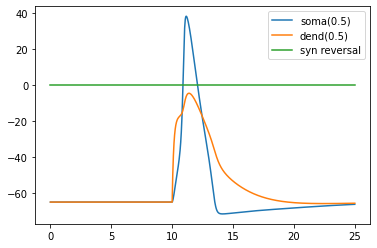

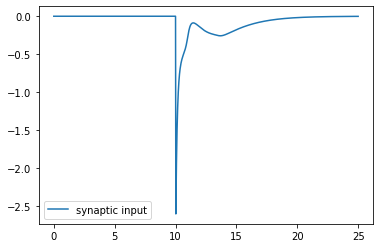

In [6]:
import matplotlib.pyplot as plt
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.plot([t[0],t[-1]],[syn_.e,syn_.e],label='syn reversal')
plt.legend()
plt.show()

plt.plot(t,syn_i, label='synaptic input')
plt.legend()
plt.show()

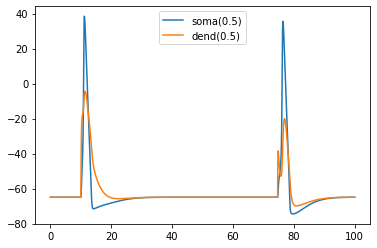

In [7]:
# Connecting the cells
syns = []
netcons = []
for source,target in zip(my_cells, my_cells[1:]+[my_cells[0]]):
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec = source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

In [8]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

h.finitialize(-65 * mV)
h.continuerun(100 * ms)

for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

cell 0: [10.925000000099914, 76.17500000010875]
cell 1: [17.450000000099543, 82.70000000011024]
cell 2: [23.975000000099172, 89.22500000011172]
cell 3: [30.5000000000988, 95.7500000001132]
cell 4: [37.02500000009986]
cell 5: [43.55000000010134]
cell 6: [50.075000000102825]
cell 7: [56.60000000010431]
cell 8: [63.12500000010579]
cell 9: [69.65000000010727]


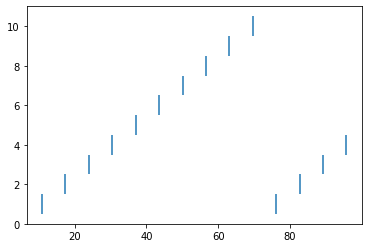

In [9]:
plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(spike_times_vec, i + 0.5, i + 1.5)
plt.show()

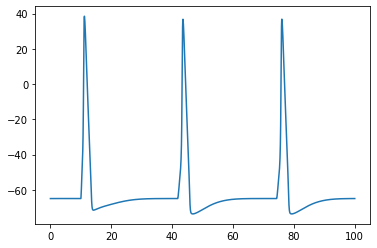

In [10]:
# Test the ring structure

ring = Ring(N=5)
shape_window = h.PlotShape(True)
shape_window.show(0)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)

plt.plot(t, ring.cells[0].soma_v)
plt.show()

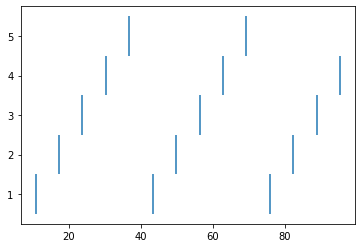

: 

In [11]:
plt.figure()
for i, cell in enumerate(ring.cells):
    plt.vlines(cell.spike_times, i + 0.5, i + 1.5)
plt.show()